#  NLP_ENDOPATHS_NER

Perform Named Entity Recognition (NER) on the Endopath dataset

Author: Nicolai Wolpert
Email: nicolai.wolpert@capgemini.com
Date: July 2024

## Imports

In [1]:
### Imports ###

# Data manipulation and other stuff : 
import numpy as np
import pandas as pd
import re
import string
import os
#pd.set_option('display.max_rows', 10)
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display
from tqdm import tqdm

from preprocess_NLP import from_X_split_get_Y_split
from sklearn.utils import resample, shuffle

# Utils for NLP : 
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

# Utils for encoding : 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

# Utils for regression : 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC

# Utils for Multilabel classification :
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Utils for Metrics calculation : 
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, hamming_loss, accuracy_score, jaccard_score, classification_report, roc_auc_score
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, roc_curve
from metrics_utils import *

from sklearn.tree import plot_tree

# Multiclass/Multilabel preparation :
from sklearn.base import BaseEstimator, ClassifierMixin

# Kfold cross-validation with stratification
from Opti_utils.ML_utils import kfold_cv_stratified
from Opti_utils.ML_utils import Binarisation

# Custom preprocessing : 
from preprocess_NLP import correction_series, lowercase_text, remove_special_characters, remove_number

# Tensorflow/keras
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import *
from tensorflow.keras.utils import to_categorical
from keras.initializers import Constant
from keras.callbacks import EarlyStopping
from keras import Sequential
from keras.layers import Embedding, LSTM, Dropout, Dense

from pprint import pprint
import functools

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from transformers import AutoModelForSequenceClassification, CamembertForMaskedLM, AutoTokenizer, AutoConfig
from datasets import load_dataset
from sklearn.metrics import confusion_matrix, f1_score

import plotly.express as px
from tqdm.notebook import tqdm

from datasets.dataset_dict import DatasetDict
from datasets import Dataset

import pickle

from nlstruct.recipes import train_ner
from nlstruct import load_pretrained
from nlstruct.datasets import load_from_brat, export_to_brat
from nlstruct.recipes import train_qualified_ner

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter

[nltk_data] Downloading package stopwords to /home/nounou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2025-01-24 15:26:12.830968: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-24 15:26:12.948273: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-24 15:26:19.018132: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/nounou/.cache/pypoetry/virtualenvs/endopaths-SLKnt0t7-py3.10/lib/python3.10/site-packages/numpy/core/getlimits.py:542:

In [2]:
model_dir = 'models/'
pred_dir = 'predictions/'
data_dir = 'Data/'

## Load data

In [3]:
# Loading X : 
df_nlp = pd.read_csv('Data/DATA_PROCESSED/donnees_entree_nlp_sans_endo.csv', usecols=['Anonymisation', 'Date', 'Nature', 'Résumé'])
df_nlp_orig = df_nlp.copy()
print('X shape is :', df_nlp.shape)

# Loading Y : 
recueil_orig  = pd.read_excel('Data/DATA_RAW/Recueil (1).xlsx').drop('Unnamed: 90', axis=1)
recueil_orig = recueil_orig[['Numéro anonymat', 'atcd.endo', 'irm.lusg', 'tv.douloureux', 'irm.externe', 'sf.dig.diarrhee', 'echo.lusg', 'echo.lusd', 'ef.hormone.dpc', 'effet.hormone', 'anapath.lusd', 'anapath.lusg', 'anapath.torus', 'anapath.autre']]
recueil = recueil_orig.copy()
recueil.replace(['Na', 'NA'], np.nan, inplace=True)
recueil = recueil.rename(columns={'Numéro anonymat': 'Anonymisation'})
# Note the target variable, if endometriosis is present or not (corresponds to the anapth columns but not 'autre')
recueil['endometriose'] = recueil.loc[:,['anapath.lusd','anapath.lusg','anapath.torus']].sum(axis=1).apply(lambda x: Binarisation(x))
# Drop the anapath columns again
recueil = recueil[[c for c in recueil.columns if not c.startswith('anapath')]]

print(f'Nombre de patientes dans le df_nlp : {len(df_nlp.Anonymisation.unique())}')

if 'DJ-055' in list(df_nlp['Anonymisation']):
    df_nlp.loc[df_nlp['Anonymisation']=='DJ-055', 'Anonymisation'] ='NJ-055'
'NJ-055' in list(df_nlp['Anonymisation'])
'DJ-055' in list(df_nlp['Anonymisation'])

# Text correction/preparation
df_nlp.Résumé = df_nlp.Résumé.apply(remove_special_characters)
df_nlp.Résumé = df_nlp.Résumé.apply(lowercase_text)
df_nlp.Résumé = df_nlp.Résumé.apply(correction_series)

# Merge receuil and nlp dataframes and rename columns
#df_nlp = df_nlp.groupby('Anonymisation')['Résumé'].agg(' '.join).reset_index()  # join all texts for patients
data = pd.merge(df_nlp, recueil, on='Anonymisation', how='inner')
data = data.rename(columns={'Anonymisation': 'patient', 'Résumé': 'text'})
data = data.replace({0: 'absent', 1: 'present'})

X shape is : (1137, 4)


/tmp/ipykernel_6068/53629194.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  recueil.replace(['Na', 'NA'], np.nan, inplace=True)


Nombre de patientes dans le df_nlp : 178


In [ ]:
data

,patient,Date,Nature,text,atcd.endo,irm.lusg,tv.douloureux,irm.externe,sf.dig.diarrhee,echo.lusg,echo.lusd,ef.hormone.dpc,effet.hormone,endometriose
0,AA-071,2019-12-08,Ordonnance,1 en cas d hystéroscopie avant la ménopause ...,absent,absent,absent,present,present,absent,present,absent,present,present
1,AA-071,2018-10-29,Ordonnance,rectosonographie échographie pelvienne avec c...,absent,absent,absent,present,present,absent,present,absent,present,present
2,AA-071,2019-09-16,Ordonnance,cerazette 1 comprimé par jour sans interrupt...,absent,absent,absent,present,present,absent,present,absent,present,present
3,AA-071,2019-09-17,Ordonnance,mopral 20 mg 1 gélule le soir pendant 15 jou...,absent,absent,absent,present,present,absent,present,absent,present,present
4,AA-071,2021-04-05,Ordonnance,dispositif intra utérin hormonal mirena 1 un...,absent,absent,absent,present,present,absent,present,absent,present,present
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016,YC-171,2020-09-24,Ordonnance,dienogest comprimé à 2 mg sawis dimetrum ...,absent,present,NaN,present,absent,absent,present,NaN,present,present
1017,YC-171,2020-09-24,Ordonnance,rectosonographie échographie pelvienne avec c...,absent,present,NaN,present,absent,absent,present,NaN,present,present
1018,YL-124,2020-08-17,Consultation,post opus lutenyl le 22 07 20 désir de grosse...,present,present,present,absent,present,present,absent,present,present,present
1019,YL-124,2020-07-19,Mots,doute sur un petit épaississement nodulaire de...,present,present,present,absent,present,present,absent,present,present,present


## NER

### Gliner

In [5]:
from gliner import GLiNER

model = GLiNER.from_pretrained("almanach/camembert-bio-gliner-v0.1")

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.05k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/542M [00:00<?, ?B/s]

gliner_config.json:   0%|          | 0.00/317 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.76k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.32M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/374 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/710 [00:00<?, ?B/s]

In [6]:
labels = ["Âge", "Patient", "Maladie", "Symptômes", "Médicament"]
if os.path.isfile(data_dir + 'Generate/df_entities.csv'):
    df_entities = pd.read_csv(data_dir + 'Generate/df_entities.csv')
else:
    df_entities = pd.DataFrame(columns=list(data.columns) + ['term', 'label', 'score'])
    for idx in tqdm(data.index):  # Loop through desired indices
        entities = model.predict_entities(data.loc[idx, 'text'], labels, threshold=0.5)
        for entity in entities:
            df_entity = data.loc[idx].copy()
            df_entity['term'] = entity["text"]
            df_entity['label'] = entity["label"]
            df_entity['score'] = entity["score"]
            df_entity = df_entity.to_frame().T  # Convert to DataFrame to concat
            df_entities = pd.concat([df_entities, df_entity], ignore_index=True)
    df_entities.to_csv(data_dir + 'Generate/df_entities.csv')
# Keep only unique terms one per patient
if os.path.isfile(data_dir + 'Generate/df_entities_unique.csv'):
    df_entities_unique = pd.read_csv(data_dir + 'Generate/df_entities_unique.csv')
else:
    df_entities_unique = pd.DataFrame()
    for patient in tqdm(list(pd.unique(df_entities.patient))):
        
        df_entities_unique_patient = df_entities.loc[df_entities.patient==patient]
        df_entities_unique_patient.drop_duplicates(subset=['term'], keep='first',inplace=True)
        df_entities_unique = pd.concat([df_entities_unique, df_entities_unique_patient])
    df_entities_unique.to_csv(data_dir + 'Generate/df_entities_unique.csv')
df_entities_unique

  0%|          | 0/1021 [00:00<?, ?it/s]

/home/nounou/.cache/pypoetry/virtualenvs/endopaths-SLKnt0t7-py3.10/lib/python3.10/site-packages/gliner/data_processing/processor.py:206: UserWarning: Sentence of length 702 has been truncated to 384
  warnings.warn(f"Sentence of length {len(tokens)} has been truncated to {max_len}")


OSError: Cannot save file into a non-existent directory: 'Data/Generate'

In [7]:
# Extract all terms by type of label
medications_patients_with_endometriosis = list(df_entities_unique.loc[(df_entities_unique['endometriose']=='present') & (df_entities_unique['label']=='Médicament'), 'term'])
medications_patients_without_endometriosis = list(df_entities_unique.loc[(df_entities_unique ['endometriose']=='absent') & (df_entities_unique['label']=='Médicament'), 'term'])

symptoms_patients_with_endometriosis = list(df_entities_unique.loc[(df_entities_unique['endometriose']=='present') & (df_entities_unique['label']=='Symptômes'), 'term'])
symptoms_patients_without_endometriosis = list(df_entities_unique.loc[(df_entities_unique ['endometriose']=='absent') & (df_entities_unique['label']=='Symptômes'), 'term'])

sicknesses_patients_with_endometriosis = list(df_entities_unique.loc[(df_entities_unique['endometriose']=='present') & (df_entities_unique['label']=='Maladie'), 'term'])
sicknesses_patients_without_endometriosis = list(df_entities_unique.loc[(df_entities_unique ['endometriose']=='absent') & (df_entities_unique['label']=='Maladie'), 'term'])

# Cleaning
medications_patients_with_endometriosis = [term for term in medications_patients_with_endometriosis if len(term) > 2]
medications_patients_without_endometriosis = [term for term in medications_patients_without_endometriosis if len(term) > 2]
symptoms_patients_with_endometriosis = [term for term in symptoms_patients_with_endometriosis if len(term) > 2]
symptoms_patients_without_endometriosis = [term for term in symptoms_patients_without_endometriosis if len(term) > 2]
sicknesses_patients_with_endometriosis = [term for term in sicknesses_patients_with_endometriosis if len(term) > 2]
sicknesses_patients_without_endometriosis = [term for term in sicknesses_patients_without_endometriosis if len(term) > 2]

# Merge across types
terms_patients_with_endometriosis = medications_patients_with_endometriosis + symptoms_patients_with_endometriosis + sicknesses_patients_with_endometriosis
terms_patients_without_endometriosis = medications_patients_without_endometriosis + symptoms_patients_without_endometriosis + sicknesses_patients_without_endometriosis

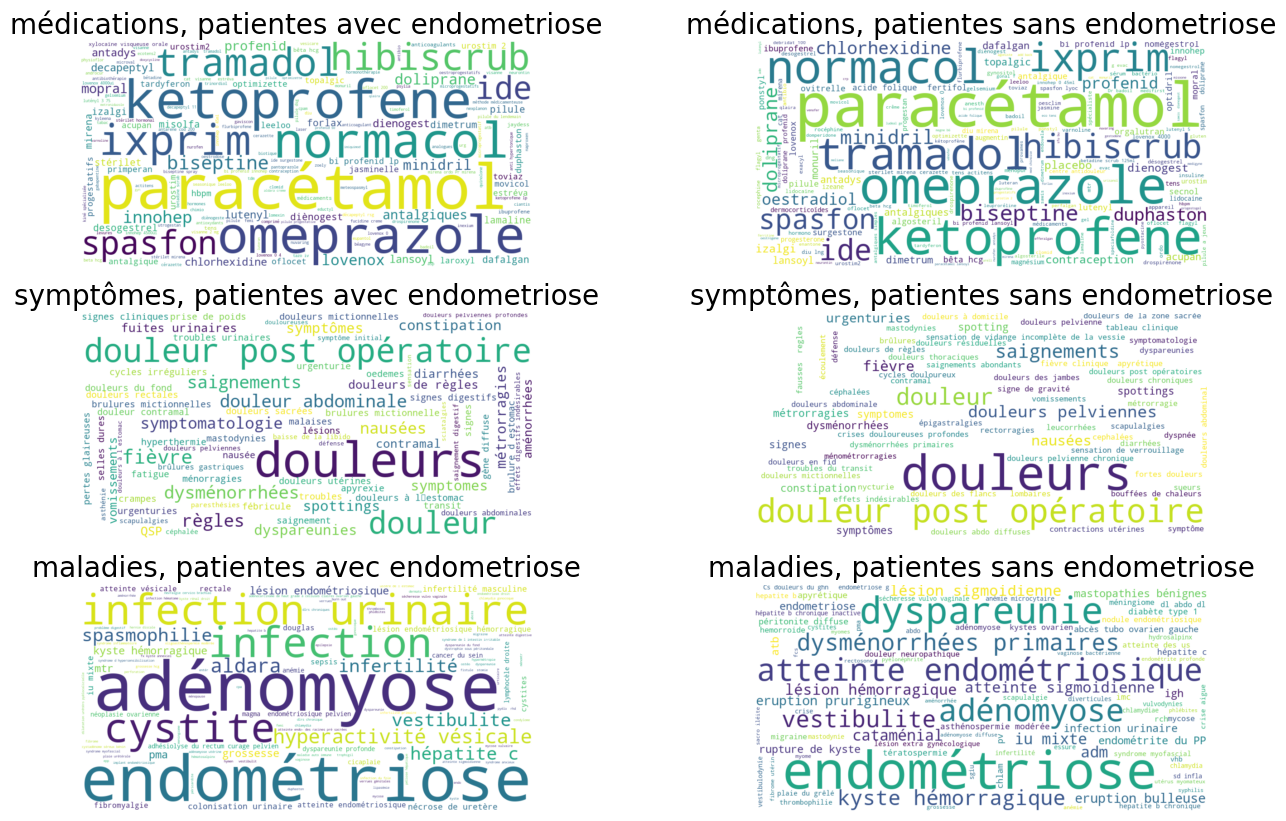

In [9]:
### Wordclouds, by type and presence of endometriosis

wordcloud_medications_with_endo = WordCloud(width = 1000, height = 500, background_color='white').generate_from_frequencies(Counter(medications_patients_with_endometriosis))
wordcloud_medications_without_endo = WordCloud(width = 1000, height = 500, background_color='white').generate_from_frequencies(Counter(medications_patients_without_endometriosis))

wordcloud_symptoms_with_endo = WordCloud(width = 1000, height = 500, background_color='white').generate_from_frequencies(Counter(symptoms_patients_with_endometriosis))
wordcloud_symptoms_without_endo = WordCloud(width = 1000, height = 500, background_color='white').generate_from_frequencies(Counter(symptoms_patients_without_endometriosis))

wordcloud_sicknesses_with_endo = WordCloud(width = 1000, height = 500, background_color='white').generate_from_frequencies(Counter(sicknesses_patients_with_endometriosis))
wordcloud_sicknesses_without_endo = WordCloud(width = 1000, height = 500, background_color='white').generate_from_frequencies(Counter(sicknesses_patients_without_endometriosis))

fig, axs = plt.subplots(3, 2, figsize=(17, 10))
axs[0, 0].imshow(wordcloud_medications_with_endo, interpolation='bilinear')
axs[0, 0].axis("off")
axs[0, 0].set_title('médications, patientes avec endometriose', fontsize=20)
axs[0, 1].imshow(wordcloud_medications_without_endo, interpolation='bilinear')
axs[0, 1].axis("off")
axs[0, 1].set_title('médications, patientes sans endometriose', fontsize=20)

axs[1, 0].imshow(wordcloud_symptoms_with_endo, interpolation='bilinear')
axs[1, 0].axis("off")
axs[1, 0].set_title('symptômes, patientes avec endometriose', fontsize=20)
axs[1, 1].imshow(wordcloud_symptoms_without_endo, interpolation='bilinear')
axs[1, 1].axis("off")
axs[1, 1].set_title('symptômes, patientes sans endometriose', fontsize=20)

axs[2, 0].imshow(wordcloud_sicknesses_with_endo, interpolation='bilinear')
axs[2, 0].axis("off")
axs[2, 0].set_title('maladies, patientes avec endometriose', fontsize=20)
axs[2, 1].imshow(wordcloud_sicknesses_without_endo, interpolation='bilinear')
axs[2, 1].axis("off")
axs[2, 1].set_title('maladies, patientes sans endometriose', fontsize=20)
plt.subplots_adjust(wspace=0.05)
#plt.tight_layout()
plt.show()

In [10]:
Counter(medications_patients_with_endometriosis)
Counter(medications_patients_without_endometriosis)
Counter(symptoms_patients_with_endometriosis)
Counter(symptoms_patients_without_endometriosis)
Counter(sicknesses_patients_with_endometriosis)
Counter(sicknesses_patients_without_endometriosis)

Counter({'endométriose': 7,
         'dyspareunie': 3,
         'atteinte endométriosique': 3,
         'adénomyose': 3,
         'dysménorrhées primaires': 2,
         'vestibulite': 2,
         'kyste hémorragique': 2,
         'iu mixte': 1,
         'cataménial': 1,
         'adm': 1,
         'lésion hémorragique': 1,
         'atteinte sigmoidienne': 1,
         'lésion sigmoidienne': 1,
         'eruption prurigineux': 1,
         'eruption bulleuse': 1,
         'mastopathies bénignes': 1,
         'endometriose': 1,
         'endométrite du PP': 1,
         'atb': 1,
         'igh': 1,
         'rupture de kyste': 1,
         'infection urinaire': 1,
         'abcès tubo ovarien gauche': 1,
         'chlam    pv': 1,
         'apyrétique': 1,
         'péritonite diffuse': 1,
         'asthénospermie modérée': 1,
         'tératospermie': 1,
         'hépatite c': 1,
         'imc': 1,
         'diabète type 1': 1,
         'adénomyose  kystes ovarien': 1,
         'rch': 1,
 

In [16]:
Counter(sicknesses_patients_without_endometriosis)

Counter({'endométriose': 7,
         'dyspareunie': 3,
         'atteinte endométriosique': 3,
         'adénomyose': 3,
         'dysménorrhées primaires': 2,
         'vestibulite': 2,
         'kyste hémorragique': 2,
         'iu mixte': 1,
         'cataménial': 1,
         'adm': 1,
         'lésion hémorragique': 1,
         'atteinte sigmoidienne': 1,
         'lésion sigmoidienne': 1,
         'eruption prurigineux': 1,
         'eruption bulleuse': 1,
         'mastopathies bénignes': 1,
         'endometriose': 1,
         'endométrite du PP': 1,
         'atb': 1,
         'igh': 1,
         'rupture de kyste': 1,
         'infection urinaire': 1,
         'abcès tubo ovarien gauche': 1,
         'chlam    pv': 1,
         'apyrétique': 1,
         'péritonite diffuse': 1,
         'asthénospermie modérée': 1,
         'tératospermie': 1,
         'hépatite c': 1,
         'imc': 1,
         'diabète type 1': 1,
         'adénomyose  kystes ovarien': 1,
         'rch': 1,
 

C:\Users\nwolpert\AppData\Local\Temp\ipykernel_352\1438570931.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='word', x='frequency', data=df_word_freq_with_endo, palette='viridis', ax = axs[0])
C:\Users\nwolpert\AppData\Local\Temp\ipykernel_352\1438570931.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='word', x='frequency', data=df_word_freq_without_endo, palette='viridis', ax = axs[1])


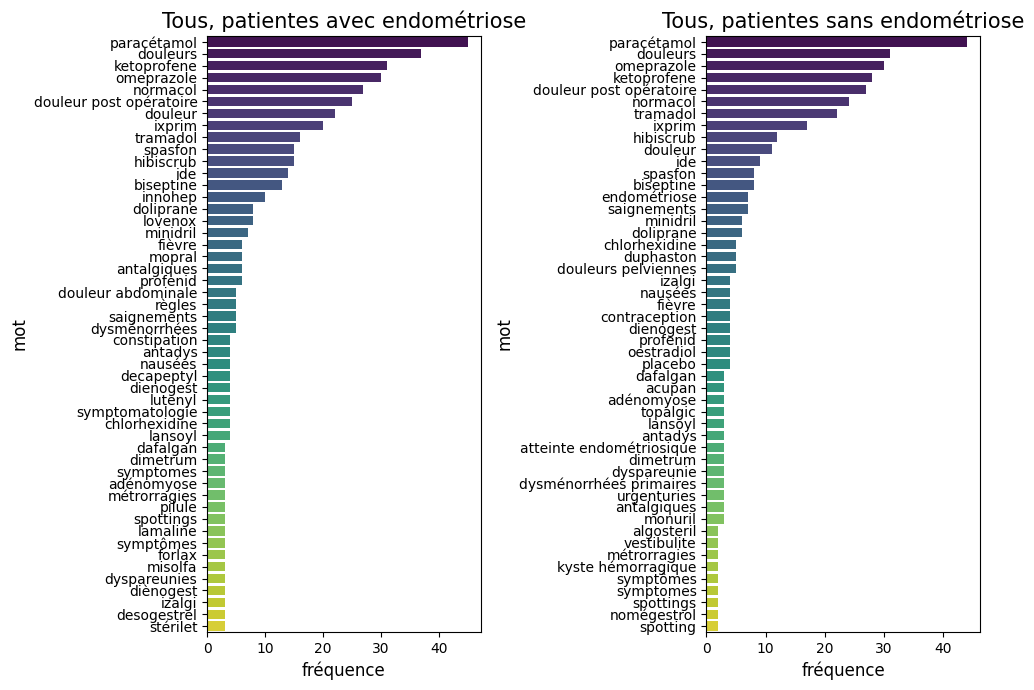

In [10]:
### Show barplot with most common words
nmostfrequent = 50
typelabel = 'Tous'

if typelabel == 'Médicaments':
    with_endo = medications_patients_with_endometriosis
    without_endo = medications_patients_without_endometriosis
if typelabel == 'Symptômes':
    with_endo = symptoms_patients_with_endometriosis
    without_endo = symptoms_patients_without_endometriosis
elif typelabel == 'Maladies':
    with_endo = sicknesses_patients_with_endometriosis
    without_endo = sicknesses_patients_without_endometriosis
elif typelabel == 'Tous':
    with_endo = terms_patients_with_endometriosis
    without_endo = terms_patients_without_endometriosis

freq_medications_with_endo = Counter(with_endo)
df_word_freq_with_endo  = pd.DataFrame(freq_medications_with_endo.items(), columns=['word', 'frequency']).sort_values(by='frequency', ascending=False).head(nmostfrequent)

freq_without_endo = Counter(without_endo)
df_word_freq_without_endo  = pd.DataFrame(freq_without_endo.items(), columns=['word', 'frequency']).sort_values(by='frequency', ascending=False).head(nmostfrequent)

# Plot the horizontal barplot
fig, axs = plt.subplots(1, 2, figsize=(10, 7))
axs = axs.flatten()
sns.barplot(y='word', x='frequency', data=df_word_freq_with_endo, palette='viridis', ax = axs[0])
axs[0].set_title(f'{typelabel}, patientes avec endométriose', fontsize=15)
axs[0].set_xlabel('fréquence', fontsize=12)
axs[0].set_ylabel('mot', fontsize=12)
sns.barplot(y='word', x='frequency', data=df_word_freq_without_endo, palette='viridis', ax = axs[1])
axs[1].set_title(f'{typelabel}, patientes sans endométriose', fontsize=15)
axs[1].set_xlabel('fréquence', fontsize=12)
axs[1].set_ylabel('mot', fontsize=12)
plt.tight_layout()
plt.show()

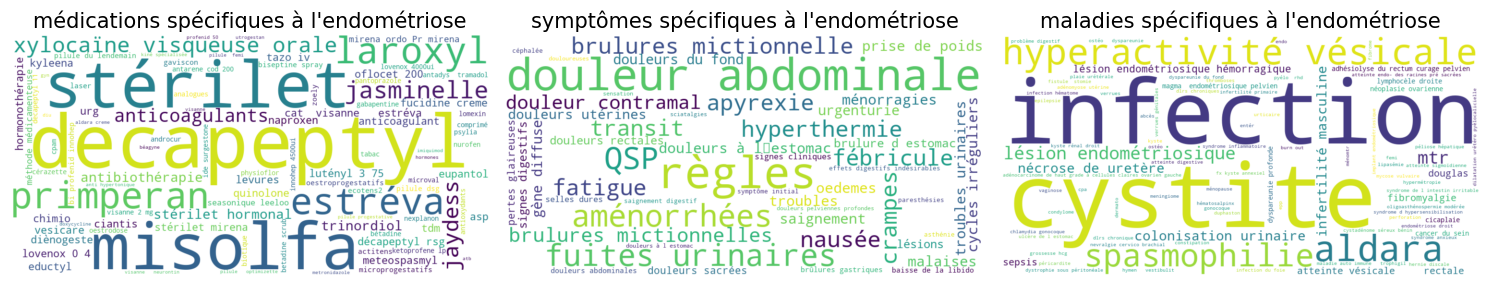

In [11]:
### Terms specific to endometriosis, by type

medications_patients_only_endometriosis = [term for term in medications_patients_with_endometriosis if term in list(set(medications_patients_with_endometriosis) - set(medications_patients_without_endometriosis))]
symptoms_patients_only_endometriosis = [term for term in symptoms_patients_with_endometriosis if term in list(set(symptoms_patients_with_endometriosis) - set(symptoms_patients_without_endometriosis))]
sicknesses_patients_only_endometriosis = [term for term in sicknesses_patients_with_endometriosis if term in list(set(sicknesses_patients_with_endometriosis) - set(sicknesses_patients_without_endometriosis))]

wordcloud_medications_patients_only_endometriosis = WordCloud(width = 1000, height = 500, background_color='white').generate_from_frequencies(Counter(medications_patients_only_endometriosis))
wordcloud_symptoms_patients_only_endometriosis = WordCloud(width = 1000, height = 500, background_color='white').generate_from_frequencies(Counter(symptoms_patients_only_endometriosis))
wordcloud_sicknesses_patients_only_endometriosis = WordCloud(width = 1000, height = 500, background_color='white').generate_from_frequencies(Counter(sicknesses_patients_only_endometriosis))

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs = axs.flatten()
axs[0].imshow(wordcloud_medications_patients_only_endometriosis, interpolation='bilinear')
axs[0].axis("off")
axs[0].set_title('médications spécifiques à l\'endométriose', fontsize=15)
axs[1].imshow(wordcloud_symptoms_patients_only_endometriosis, interpolation='bilinear')
axs[1].axis("off")
axs[1].set_title('symptômes spécifiques à l\'endométriose', fontsize=15)
axs[2].imshow(wordcloud_sicknesses_patients_only_endometriosis, interpolation='bilinear')
axs[2].axis("off")
axs[2].set_title('maladies spécifiques à l\'endométriose', fontsize=15)

plt.tight_layout()
plt.show()

,word,frequency
8,decapeptyl,4
13,stérilet,3
23,misolfa,3
46,jasminelle,2
45,laroxyl,2
58,xylocaïne visqueuse orale,2
21,primperan,2
33,estréva,2
72,anticoagulants,2
62,jaydess,2


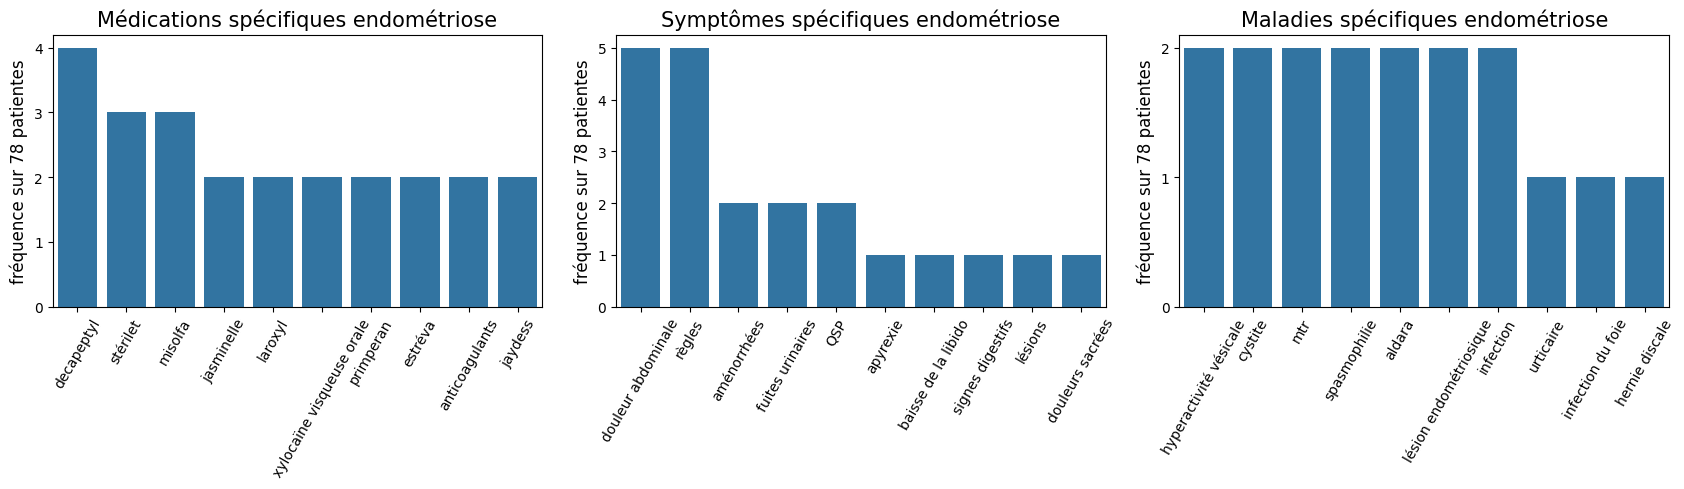

In [23]:
### Show barplot with most common words
nmostfrequent = 10

patients_with_endo = list(pd.unique(df_entities_unique.loc[(df_entities_unique['endometriose']=='present'), 'patient']))
npatients_with_endo = len(patients_with_endo)

freq_medications_only_endo = Counter(medications_patients_only_endometriosis)
df_freq_medications_only_endo  = pd.DataFrame(freq_medications_only_endo.items(), columns=['word', 'frequency']).sort_values(by='frequency', ascending=False).head(nmostfrequent)
df_freq_medications_only_endo['percentage'] = df_freq_medications_only_endo['frequency'] / npatients_with_endo

freq_symptoms_only_endo = Counter(symptoms_patients_only_endometriosis)
df_freq_symptoms_only_endo  = pd.DataFrame(freq_symptoms_only_endo.items(), columns=['word', 'frequency']).sort_values(by='frequency', ascending=False).head(nmostfrequent)
df_freq_symptoms_only_endo['percentage'] = df_freq_symptoms_only_endo['frequency'] / npatients_with_endo

freq_sicknesses_only_endo = Counter(sicknesses_patients_only_endometriosis)
df_freq_sicknesses_only_endo  = pd.DataFrame(freq_sicknesses_only_endo.items(), columns=['word', 'frequency']).sort_values(by='frequency', ascending=False).head(nmostfrequent)
df_freq_sicknesses_only_endo['percentage'] = df_freq_sicknesses_only_endo['frequency'] / npatients_with_endo

# Choose if to plot absolute number of patients or percentage
plot_type = 'absolute'

# Plot the horizontal barplot
fig, axs = plt.subplots(1, 3, figsize=(17, 5))
axs = axs.flatten()
if plot_type == 'absolute':
    sns.barplot(y='frequency', x='word', data=df_freq_medications_only_endo, ax = axs[0])
    axs[0].set_ylabel(f'fréquence sur {npatients_with_endo} patientes', fontsize=12)
elif plot_type == 'percentage':
    sns.barplot(y='percentage', x='word', data=df_freq_medications_only_endo, ax = axs[0])
    axs[0].set_ylabel('percentage des patientes', fontsize=12)
axs[0].set_title(f'Médications spécifiques endométriose', fontsize=15)

axs[0].set_xlabel('', fontsize=12)
axs[0].yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
for tick in axs[0].get_xticklabels():
    tick.set_rotation(60)
if plot_type == 'absolute':
    sns.barplot(y='frequency', x='word', data=df_freq_symptoms_only_endo, ax = axs[1])
    axs[1].set_ylabel(f'fréquence sur {npatients_with_endo} patientes', fontsize=12)
elif plot_type == 'percentage':
    sns.barplot(y='percentage', x='word', data=df_freq_medications_only_endo, ax = axs[1])
    axs[1].set_ylabel('percentage des patientes', fontsize=12)
axs[1].set_title(f'Symptômes spécifiques endométriose', fontsize=15)
axs[1].set_xlabel('', fontsize=12)
axs[1].yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
for tick in axs[1].get_xticklabels():
    tick.set_rotation(60)
if plot_type == 'absolute':
    sns.barplot(y='frequency', x='word', data=df_freq_sicknesses_only_endo, ax = axs[2])
    axs[2].set_ylabel(f'fréquence sur {npatients_with_endo} patientes', fontsize=12)
elif plot_type == 'percentage':
    sns.barplot(y='percentage', x='word', data=df_freq_medications_only_endo, ax = axs[2])
    axs[2].set_ylabel('percentage des patientes', fontsize=12)
axs[2].set_title(f'Maladies spécifiques endométriose', fontsize=15)
axs[2].set_xlabel('', fontsize=12)
axs[2].yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
for tick in axs[2].get_xticklabels():
    tick.set_rotation(60)
plt.tight_layout()
plt.show()

In [24]:
'spasfon' in medications_patients_only_endometriosis

False

In [42]:
npatients_with_endo = len(pd.unique(data.loc[data['endometriose']=='present', 'patient']))
npatients_without_endo = len(pd.unique(data.loc[data['endometriose']=='absent', 'patient']))
npatients_without_endo

74

In [43]:
npatients_with_endo

83

In [44]:
### Compare frequency of termes in patients with vs. without endometriosis

'''
# Select only terms with at least a frequency of this number
cutofffreq = 10
'''

freq_with_endo = Counter(terms_patients_with_endometriosis)
df_word_freq_with_endo  = pd.DataFrame(freq_with_endo.items(), columns=['word', 'absolute_frequency']).sort_values(by='absolute_frequency', ascending=False)
#df_word_freq_with_endo = df_word_freq_with_endo.loc[df_word_freq_with_endo['absolute_frequency'] >= cutofffreq]

freq_without_endo = Counter(terms_patients_without_endometriosis)
df_word_freq_without_endo  = pd.DataFrame(freq_without_endo.items(), columns=['word', 'absolute_frequency']).sort_values(by='absolute_frequency', ascending=False)
#df_word_freq_without_endo = df_word_freq_without_endo.loc[df_word_freq_without_endo['absolute_frequency'] >= cutofffreq]

### Compute term frequency relative to the corpus

absolute_frequencies_with_endo = df_word_freq_with_endo['absolute_frequency']
nwords_total_with_endometriosis = sum(data.loc[data['endometriose']=='present', 'text'].str.count(' ') + 1)
relative_frequencies_with_endo = [(freq/nwords_total_with_endometriosis) for freq in absolute_frequencies_with_endo]
relative_frequencies_with_endo = [(freq/npatients_with_endo) for freq in absolute_frequencies_with_endo]
df_word_freq_with_endo['relative_frequency'] = relative_frequencies_with_endo

absolute_frequencies_without_endo = df_word_freq_without_endo['absolute_frequency']
nwords_total_without_endometriosis = sum(data.loc[data['endometriose']=='absent', 'text'].str.count(' ') + 1)
relative_frequencies_without_endo = [(freq/nwords_total_without_endometriosis) for freq in absolute_frequencies_without_endo]
relative_frequencies_without_endo = [(freq/npatients_without_endo) for freq in absolute_frequencies_without_endo]
df_word_freq_without_endo['relative_frequency'] = relative_frequencies_without_endo

# Combine the dataframes
all_words = pd.concat([df_word_freq_with_endo['word'], df_word_freq_without_endo['word']]).unique()
df_freq_with_vs_without_endo = pd.DataFrame({'word': all_words})

# Merge frequencies from both dataframes
df_freq_with_vs_without_endo = df_freq_with_vs_without_endo.merge(df_word_freq_with_endo, on='word', how='left', suffixes=('', '_with_endo'))
df_freq_with_vs_without_endo = df_freq_with_vs_without_endo.merge(df_word_freq_without_endo, on='word', how='left', suffixes=('_with_endo', '_without_endo'))

df_freq_with_vs_without_endo.fillna(0, inplace=True)

# Sort by total frequency for better visualization
df_freq_with_vs_without_endo['total_frequency'] = df_freq_with_vs_without_endo['absolute_frequency_with_endo'] + df_freq_with_vs_without_endo['absolute_frequency_without_endo']
df_freq_with_vs_without_endo['total_frequency'] = df_freq_with_vs_without_endo['total_frequency'].astype(int)
df_freq_with_vs_without_endo.sort_values('total_frequency', ascending=False, inplace=True)

# Select only terms with at least a frequency of this number
cutofffreq = 10
df_freq_with_vs_without_endo = df_freq_with_vs_without_endo.loc[(df_freq_with_vs_without_endo.absolute_frequency_with_endo >= cutofffreq) | (df_freq_with_vs_without_endo.absolute_frequency_without_endo >= cutofffreq)]

df_freq_with_vs_without_endo

,word,absolute_frequency_with_endo,relative_frequency_with_endo,absolute_frequency_without_endo,relative_frequency_without_endo,total_frequency
0,paracétamol,45.0,0.542169,44.0,0.594595,89
1,douleurs,37.0,0.445783,31.0,0.418919,68
3,omeprazole,30.0,0.361446,30.0,0.405405,60
2,ketoprofene,31.0,0.373494,28.0,0.378378,59
5,douleur post opératoire,25.0,0.301205,27.0,0.364865,52
4,normacol,27.0,0.325301,24.0,0.324324,51
8,tramadol,16.0,0.192771,22.0,0.297297,38
7,ixprim,20.0,0.240964,17.0,0.229730,37
6,douleur,22.0,0.265060,11.0,0.148649,33
10,hibiscrub,15.0,0.180723,12.0,0.162162,27


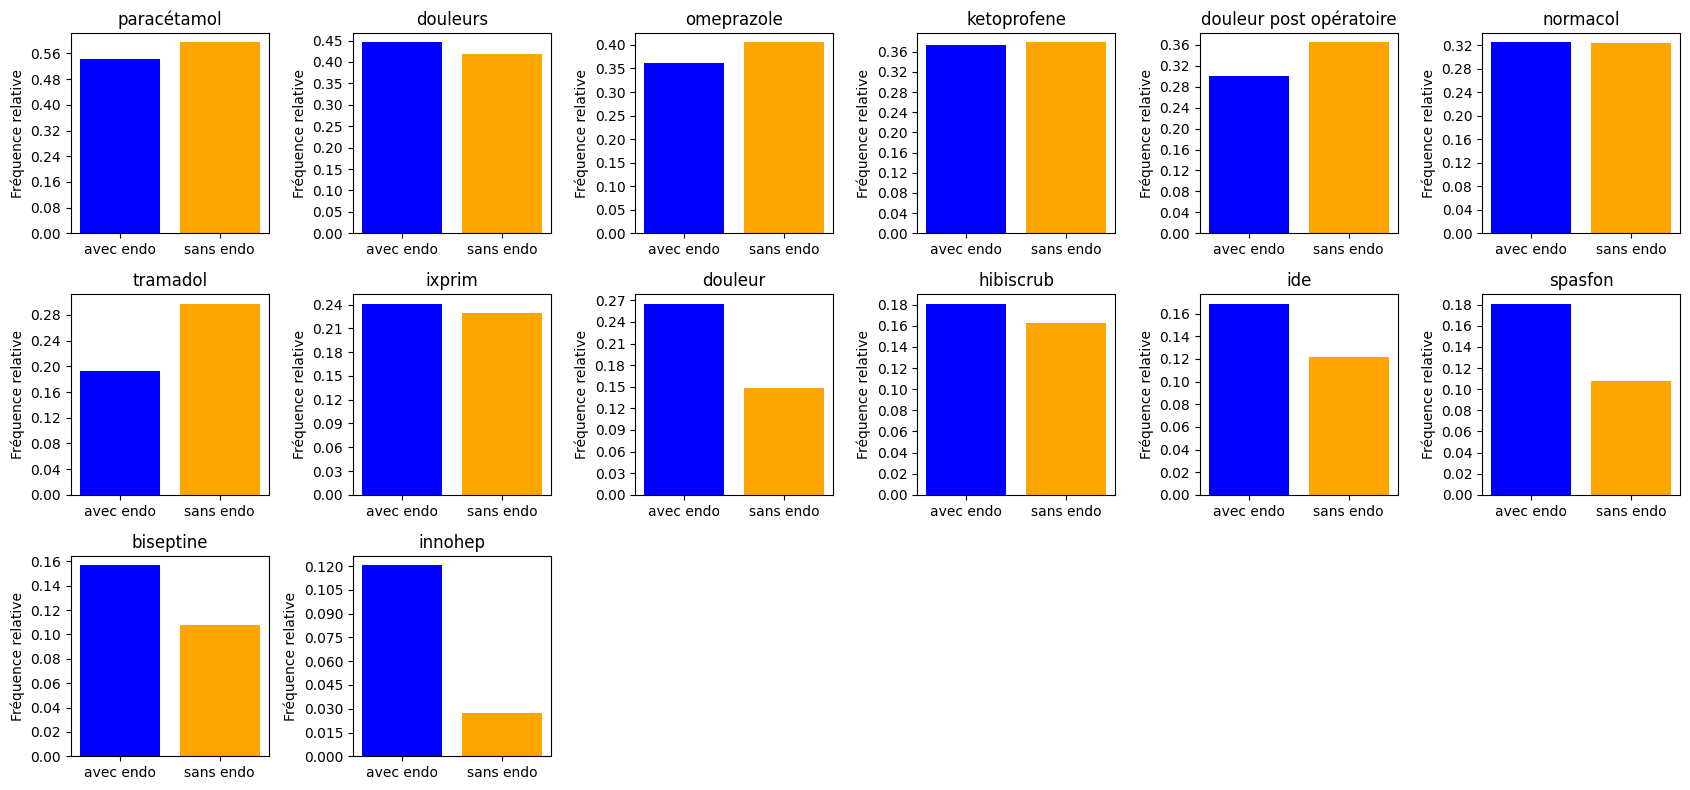

In [45]:
### Show frequency of words in patients with vs. without endometriosis

frequency = 'relative'      # 'absolute' or 'relative'

# Plotting
num_words = df_freq_with_vs_without_endo.shape[0]
ncols = 6
nrows = int(np.ceil(num_words/ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(17, 8))
axes = axes.flatten()
for i, idx in enumerate(df_freq_with_vs_without_endo.index):
    axes[i].bar(['avec endo', 'sans endo'], [df_freq_with_vs_without_endo.loc[idx, f'{frequency}_frequency_with_endo'], df_freq_with_vs_without_endo.loc[idx, f'{frequency}_frequency_without_endo']], color=['blue', 'orange'])
    axes[i].set_title(df_freq_with_vs_without_endo.loc[idx, 'word'])
    if frequency == 'absolute':
        axes[i].set_ylabel('Fréquence absolue')
    else:
        axes[i].set_ylabel('Fréquence relative')
    axes[i].yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
for i in range(i+1, nrows*ncols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

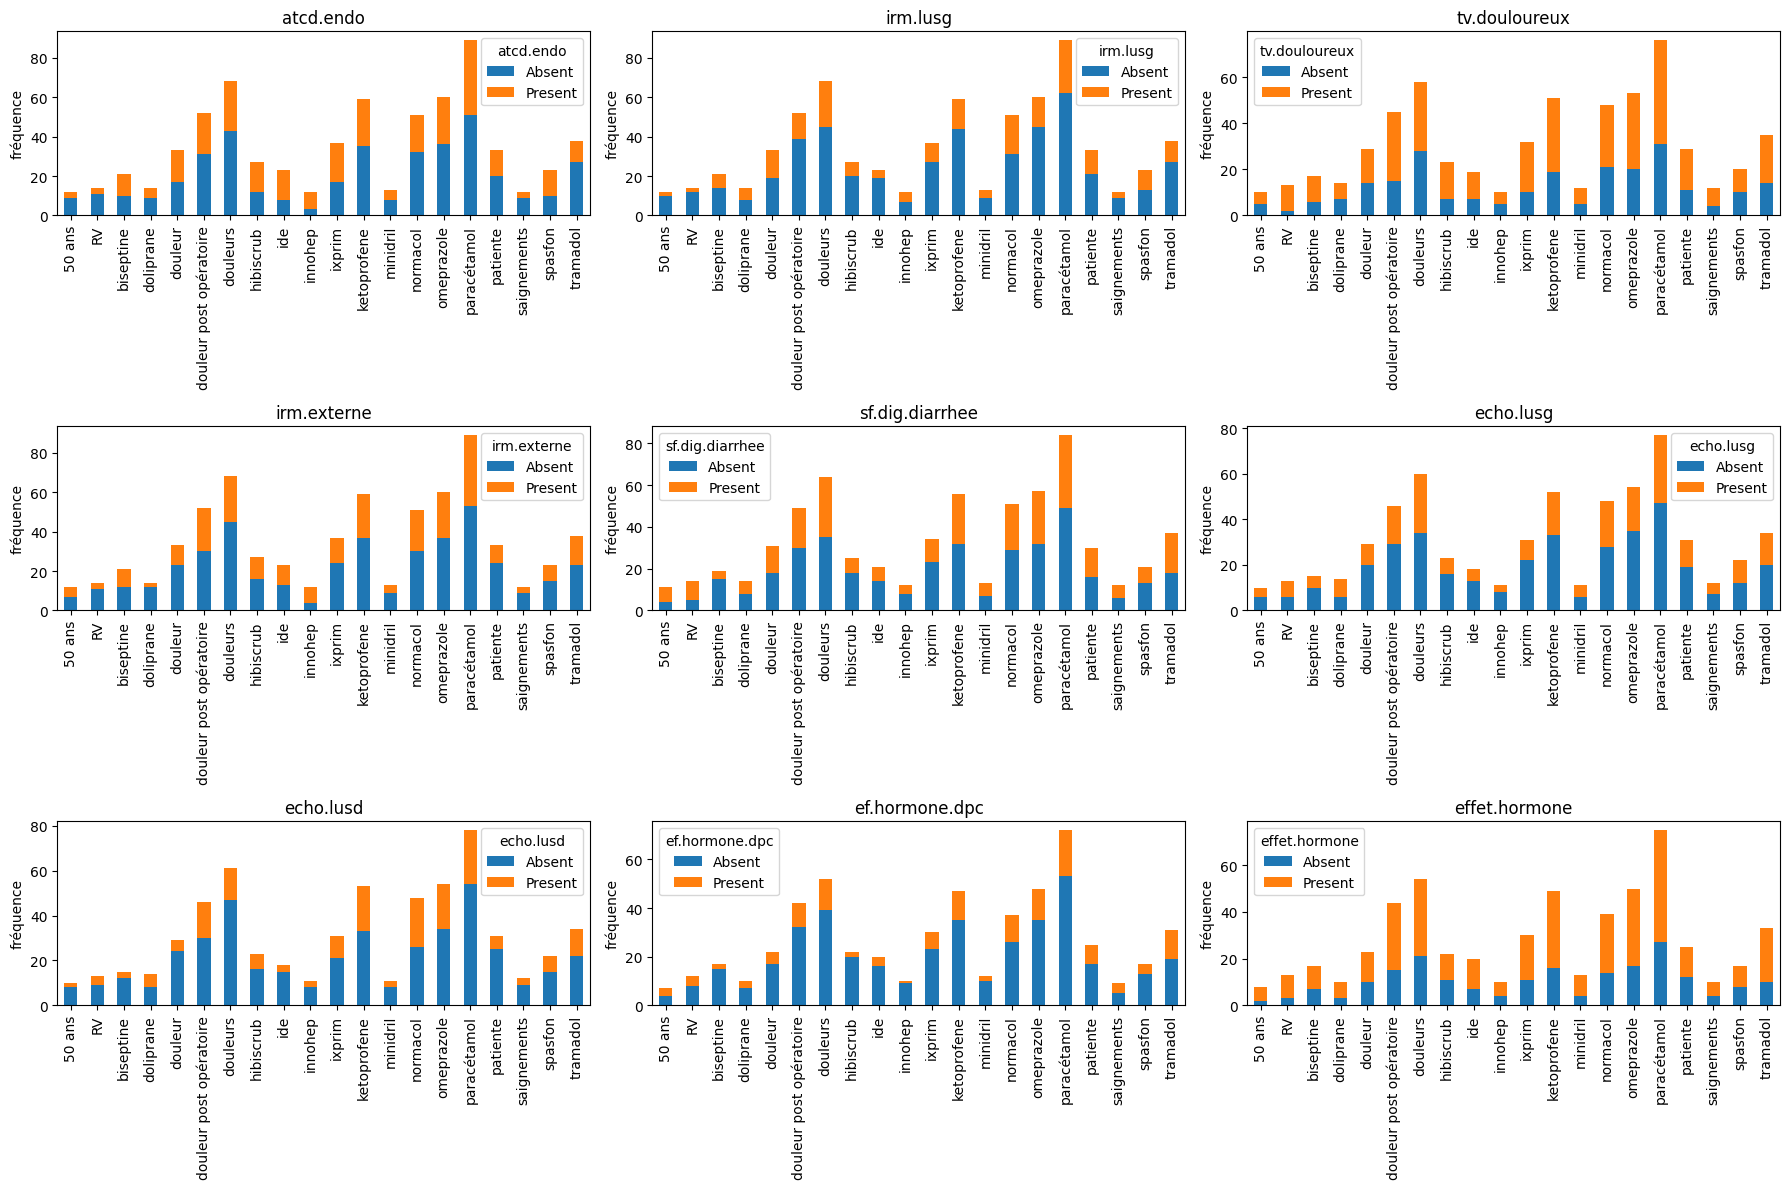

In [75]:
df = df_entities_unique.copy()
features = ['atcd.endo', 'irm.lusg', 'tv.douloureux', 'irm.externe', 
                  'sf.dig.diarrhee', 'echo.lusg', 'echo.lusd', 'ef.hormone.dpc', 'effet.hormone']

# Set the number of top terms to plot
N = 20
normalize = False

# Count the occurrences of each term
term_counts = df['term'].value_counts()

# Select the top N most frequent terms
top_terms = term_counts.head(N).index

# Filter the dataframe to include only the top N terms
df_top_terms = df[df['term'].isin(top_terms)]

# List of binary columns to analyze
binary_columns = ['atcd.endo', 'irm.lusg', 'tv.douloureux', 'irm.externe', 
                  'sf.dig.diarrhee', 'echo.lusg', 'echo.lusd', 'ef.hormone.dpc', 'effet.hormone']

# Create subplots
ncols = 3
nrows = int(np.ceil(len(features)/ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 12))
axes = axes.flatten()
# Iterate over binary columns and plot the presence vs absence for each
for ax, feature in zip(axes, features):
    feature_terms = df_top_terms.groupby(['term', feature]).size().unstack(fill_value=0)
    if normalize:
        npatientspresent = df.drop_duplicates(subset=['patient']).value_counts([feature])['present']
        npatientsabsent = df.drop_duplicates(subset=['patient']).value_counts([feature])['absent']
        feature_terms['absent'] = feature_terms['absent'] / npatientspresent
        feature_terms['present'] = feature_terms['present'] / npatientsabsent
    feature_terms.plot(kind='bar', stacked=True, ax=ax)
    ax.set_title(feature)
    ax.set_xlabel("")
    if normalize:
        ax.set_ylabel("fréquence normalisée")
    else:
        ax.set_ylabel("fréquence")
    ax.legend(title=feature, labels=['Absent', 'Present'])

plt.tight_layout()
plt.show()

In [68]:
feature_terms['absent'] / nabsent

term
50 ans                     0.046512
RV                         0.069767
biseptine                  0.162791
doliprane                  0.069767
douleur                    0.232558
douleur post opératoire    0.348837
douleurs                   0.488372
hibiscrub                  0.255814
ide                        0.162791
innohep                    0.093023
ixprim                     0.255814
ketoprofene                0.372093
minidril                   0.093023
normacol                   0.325581
omeprazole                 0.395349
paracétamol                0.627907
patiente                   0.279070
saignements                0.093023
spasfon                    0.186047
tramadol                   0.232558
Name: absent, dtype: float64

In [76]:
feature = 'effet.hormone'
df.drop_duplicates(subset=['patient']).value_counts([feature])

effet.hormone
present          79
absent           43
Name: count, dtype: int64